In [1]:
import sys
import os

# Add the root directory to sys.path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))

from dsa_analysis import load_config, visualize
import pandas as pd
from src.toolkit import compute_dissimilarity
import DSA
import similarity
import pickle
import numpy as np
import ipdb
import matplotlib.pyplot as plt
import seaborn as sns

%load_ext autoreload
%autoreload 2

/Users/qguilhot/Library/Caches/pypoetry/virtualenvs/multitask-rnn-kKi2hSus-py3.11/lib/python3.11/site-packages/gym/envs/registration.py:396: UserWarning: WARN: The `registry.all` method is deprecated. Please use `registry.values` instead.
  logger.warn(


### Load config

In [2]:
config = load_config("../config.yaml")

In [14]:
def parse_model_info(model_name):
    model_name = model_name.replace('.pth', '')
    model_name = model_name.split('_')
    model_type = model_name[0] + '_' + model_name[1]
    if len(model_name) == 7:    
        activation = model_name[2] + '_' + model_name[3]
        hidden_size = int(model_name[4])
        learning_rate = float(model_name[5])
    else:
        activation = model_name[2]
        hidden_size = int(model_name[3])
        learning_rate = float(model_name[4])
    return model_type, activation, hidden_size, learning_rate

parse_model_info('leaky_gru_tanh_128_0.001_train.pth ')



('leaky_gru', 'tanh', 128, 0.001)

### Get dynamics

In [4]:
curves = {group:[] for group in os.listdir("../models")}
explained_variances = {group:[] for group in os.listdir("../models")}
curves_names = {group:[] for group in os.listdir("../models")}
dissimilarities = {}
for group in os.listdir("../models"):
    for model in os.listdir(f"../models/{group}"):
        if not model.endswith('.pth'):
            continue
        else:
            model_type, activation, hidden_size, lr = parse_model_info(model)
            curve, explained_variance = compute_dissimilarity(
                model_type, activation, hidden_size, lr, model, group, "cpu", n_components=3 
            )
            curves[group].append(curve)
            explained_variances[group].append(explained_variance)
            curves_names[group].append(model.replace('.pth', ''))

leaky_rnn_tanh_128_0.0001__True_train_pretrain.pth


/Users/qguilhot/Library/Caches/pypoetry/virtualenvs/multitask-rnn-kKi2hSus-py3.11/lib/python3.11/site-packages/gym/envs/registration.py:396: UserWarning: WARN: The `registry.all` method is deprecated. Please use `registry.values` instead.
  logger.warn(
/Users/qguilhot/Library/Caches/pypoetry/virtualenvs/multitask-rnn-kKi2hSus-py3.11/lib/python3.11/site-packages/gym/envs/registration.py:396: UserWarning: WARN: The `registry.all` method is deprecated. Please use `registry.values` instead.
  logger.warn(
/Users/qguilhot/Library/Caches/pypoetry/virtualenvs/multitask-rnn-kKi2hSus-py3.11/lib/python3.11/site-packages/gym/envs/registration.py:396: UserWarning: WARN: The `registry.all` method is deprecated. Please use `registry.values` instead.
  logger.warn(
/Users/qguilhot/Library/Caches/pypoetry/virtualenvs/multitask-rnn-kKi2hSus-py3.11/lib/python3.11/site-packages/gym/envs/registration.py:396: UserWarning: WARN: The `registry.all` method is deprecated. Please use `registry.values` instead.

leaky_rnn_softplus_128_0.0001__False_train_pretrain.pth


/Users/qguilhot/Library/Caches/pypoetry/virtualenvs/multitask-rnn-kKi2hSus-py3.11/lib/python3.11/site-packages/gym/envs/registration.py:396: UserWarning: WARN: The `registry.all` method is deprecated. Please use `registry.values` instead.
  logger.warn(
/Users/qguilhot/Library/Caches/pypoetry/virtualenvs/multitask-rnn-kKi2hSus-py3.11/lib/python3.11/site-packages/gym/envs/registration.py:396: UserWarning: WARN: The `registry.all` method is deprecated. Please use `registry.values` instead.
  logger.warn(
/Users/qguilhot/Library/Caches/pypoetry/virtualenvs/multitask-rnn-kKi2hSus-py3.11/lib/python3.11/site-packages/gym/envs/registration.py:396: UserWarning: WARN: The `registry.all` method is deprecated. Please use `registry.values` instead.
  logger.warn(
/Users/qguilhot/Library/Caches/pypoetry/virtualenvs/multitask-rnn-kKi2hSus-py3.11/lib/python3.11/site-packages/gym/envs/registration.py:396: UserWarning: WARN: The `registry.all` method is deprecated. Please use `registry.values` instead.

leaky_rnn_tanh_128_0.0001__False_train_pretrain.pth


/Users/qguilhot/Library/Caches/pypoetry/virtualenvs/multitask-rnn-kKi2hSus-py3.11/lib/python3.11/site-packages/gym/envs/registration.py:396: UserWarning: WARN: The `registry.all` method is deprecated. Please use `registry.values` instead.
  logger.warn(
/Users/qguilhot/Library/Caches/pypoetry/virtualenvs/multitask-rnn-kKi2hSus-py3.11/lib/python3.11/site-packages/gym/envs/registration.py:396: UserWarning: WARN: The `registry.all` method is deprecated. Please use `registry.values` instead.
  logger.warn(
/Users/qguilhot/Library/Caches/pypoetry/virtualenvs/multitask-rnn-kKi2hSus-py3.11/lib/python3.11/site-packages/gym/envs/registration.py:396: UserWarning: WARN: The `registry.all` method is deprecated. Please use `registry.values` instead.
  logger.warn(
/Users/qguilhot/Library/Caches/pypoetry/virtualenvs/multitask-rnn-kKi2hSus-py3.11/lib/python3.11/site-packages/gym/envs/registration.py:396: UserWarning: WARN: The `registry.all` method is deprecated. Please use `registry.values` instead.

leaky_rnn_softplus_128_0.0001__True_train_pretrain.pth


/Users/qguilhot/Library/Caches/pypoetry/virtualenvs/multitask-rnn-kKi2hSus-py3.11/lib/python3.11/site-packages/gym/envs/registration.py:396: UserWarning: WARN: The `registry.all` method is deprecated. Please use `registry.values` instead.
  logger.warn(
/Users/qguilhot/Library/Caches/pypoetry/virtualenvs/multitask-rnn-kKi2hSus-py3.11/lib/python3.11/site-packages/gym/envs/registration.py:396: UserWarning: WARN: The `registry.all` method is deprecated. Please use `registry.values` instead.
  logger.warn(
/Users/qguilhot/Library/Caches/pypoetry/virtualenvs/multitask-rnn-kKi2hSus-py3.11/lib/python3.11/site-packages/gym/envs/registration.py:396: UserWarning: WARN: The `registry.all` method is deprecated. Please use `registry.values` instead.
  logger.warn(
/Users/qguilhot/Library/Caches/pypoetry/virtualenvs/multitask-rnn-kKi2hSus-py3.11/lib/python3.11/site-packages/gym/envs/registration.py:396: UserWarning: WARN: The `registry.all` method is deprecated. Please use `registry.values` instead.

leaky_rnn_tanh_256_0.001__True_train_pretrain.pth


/Users/qguilhot/Library/Caches/pypoetry/virtualenvs/multitask-rnn-kKi2hSus-py3.11/lib/python3.11/site-packages/gym/envs/registration.py:396: UserWarning: WARN: The `registry.all` method is deprecated. Please use `registry.values` instead.
  logger.warn(
/Users/qguilhot/Library/Caches/pypoetry/virtualenvs/multitask-rnn-kKi2hSus-py3.11/lib/python3.11/site-packages/gym/envs/registration.py:396: UserWarning: WARN: The `registry.all` method is deprecated. Please use `registry.values` instead.
  logger.warn(
/Users/qguilhot/Library/Caches/pypoetry/virtualenvs/multitask-rnn-kKi2hSus-py3.11/lib/python3.11/site-packages/gym/envs/registration.py:396: UserWarning: WARN: The `registry.all` method is deprecated. Please use `registry.values` instead.
  logger.warn(
/Users/qguilhot/Library/Caches/pypoetry/virtualenvs/multitask-rnn-kKi2hSus-py3.11/lib/python3.11/site-packages/gym/envs/registration.py:396: UserWarning: WARN: The `registry.all` method is deprecated. Please use `registry.values` instead.

leaky_rnn_softplus_256_0.0001__True_train_pretrain.pth


/Users/qguilhot/Library/Caches/pypoetry/virtualenvs/multitask-rnn-kKi2hSus-py3.11/lib/python3.11/site-packages/gym/envs/registration.py:396: UserWarning: WARN: The `registry.all` method is deprecated. Please use `registry.values` instead.
  logger.warn(
/Users/qguilhot/Library/Caches/pypoetry/virtualenvs/multitask-rnn-kKi2hSus-py3.11/lib/python3.11/site-packages/gym/envs/registration.py:396: UserWarning: WARN: The `registry.all` method is deprecated. Please use `registry.values` instead.
  logger.warn(
/Users/qguilhot/Library/Caches/pypoetry/virtualenvs/multitask-rnn-kKi2hSus-py3.11/lib/python3.11/site-packages/gym/envs/registration.py:396: UserWarning: WARN: The `registry.all` method is deprecated. Please use `registry.values` instead.
  logger.warn(
/Users/qguilhot/Library/Caches/pypoetry/virtualenvs/multitask-rnn-kKi2hSus-py3.11/lib/python3.11/site-packages/gym/envs/registration.py:396: UserWarning: WARN: The `registry.all` method is deprecated. Please use `registry.values` instead.

leaky_rnn_tanh_256_0.0001__True_train_pretrain.pth


/Users/qguilhot/Library/Caches/pypoetry/virtualenvs/multitask-rnn-kKi2hSus-py3.11/lib/python3.11/site-packages/gym/envs/registration.py:396: UserWarning: WARN: The `registry.all` method is deprecated. Please use `registry.values` instead.
  logger.warn(
/Users/qguilhot/Library/Caches/pypoetry/virtualenvs/multitask-rnn-kKi2hSus-py3.11/lib/python3.11/site-packages/gym/envs/registration.py:396: UserWarning: WARN: The `registry.all` method is deprecated. Please use `registry.values` instead.
  logger.warn(
/Users/qguilhot/Library/Caches/pypoetry/virtualenvs/multitask-rnn-kKi2hSus-py3.11/lib/python3.11/site-packages/gym/envs/registration.py:396: UserWarning: WARN: The `registry.all` method is deprecated. Please use `registry.values` instead.
  logger.warn(
/Users/qguilhot/Library/Caches/pypoetry/virtualenvs/multitask-rnn-kKi2hSus-py3.11/lib/python3.11/site-packages/gym/envs/registration.py:396: UserWarning: WARN: The `registry.all` method is deprecated. Please use `registry.values` instead.

leaky_rnn_tanh_128_0.001__True_train_pretrain.pth


/Users/qguilhot/Library/Caches/pypoetry/virtualenvs/multitask-rnn-kKi2hSus-py3.11/lib/python3.11/site-packages/gym/envs/registration.py:396: UserWarning: WARN: The `registry.all` method is deprecated. Please use `registry.values` instead.
  logger.warn(
/Users/qguilhot/Library/Caches/pypoetry/virtualenvs/multitask-rnn-kKi2hSus-py3.11/lib/python3.11/site-packages/gym/envs/registration.py:396: UserWarning: WARN: The `registry.all` method is deprecated. Please use `registry.values` instead.
  logger.warn(
/Users/qguilhot/Library/Caches/pypoetry/virtualenvs/multitask-rnn-kKi2hSus-py3.11/lib/python3.11/site-packages/gym/envs/registration.py:396: UserWarning: WARN: The `registry.all` method is deprecated. Please use `registry.values` instead.
  logger.warn(
/Users/qguilhot/Library/Caches/pypoetry/virtualenvs/multitask-rnn-kKi2hSus-py3.11/lib/python3.11/site-packages/gym/envs/registration.py:396: UserWarning: WARN: The `registry.all` method is deprecated. Please use `registry.values` instead.

leaky_rnn_softplus_128_0.001__False_train_pretrain.pth


/Users/qguilhot/Library/Caches/pypoetry/virtualenvs/multitask-rnn-kKi2hSus-py3.11/lib/python3.11/site-packages/gym/envs/registration.py:396: UserWarning: WARN: The `registry.all` method is deprecated. Please use `registry.values` instead.
  logger.warn(
/Users/qguilhot/Library/Caches/pypoetry/virtualenvs/multitask-rnn-kKi2hSus-py3.11/lib/python3.11/site-packages/gym/envs/registration.py:396: UserWarning: WARN: The `registry.all` method is deprecated. Please use `registry.values` instead.
  logger.warn(
/Users/qguilhot/Library/Caches/pypoetry/virtualenvs/multitask-rnn-kKi2hSus-py3.11/lib/python3.11/site-packages/gym/envs/registration.py:396: UserWarning: WARN: The `registry.all` method is deprecated. Please use `registry.values` instead.
  logger.warn(
/Users/qguilhot/Library/Caches/pypoetry/virtualenvs/multitask-rnn-kKi2hSus-py3.11/lib/python3.11/site-packages/gym/envs/registration.py:396: UserWarning: WARN: The `registry.all` method is deprecated. Please use `registry.values` instead.

leaky_rnn_softplus_256_0.0001__False_train_pretrain.pth


/Users/qguilhot/Library/Caches/pypoetry/virtualenvs/multitask-rnn-kKi2hSus-py3.11/lib/python3.11/site-packages/gym/envs/registration.py:396: UserWarning: WARN: The `registry.all` method is deprecated. Please use `registry.values` instead.
  logger.warn(
/Users/qguilhot/Library/Caches/pypoetry/virtualenvs/multitask-rnn-kKi2hSus-py3.11/lib/python3.11/site-packages/gym/envs/registration.py:396: UserWarning: WARN: The `registry.all` method is deprecated. Please use `registry.values` instead.
  logger.warn(
/Users/qguilhot/Library/Caches/pypoetry/virtualenvs/multitask-rnn-kKi2hSus-py3.11/lib/python3.11/site-packages/gym/envs/registration.py:396: UserWarning: WARN: The `registry.all` method is deprecated. Please use `registry.values` instead.
  logger.warn(
/Users/qguilhot/Library/Caches/pypoetry/virtualenvs/multitask-rnn-kKi2hSus-py3.11/lib/python3.11/site-packages/gym/envs/registration.py:396: UserWarning: WARN: The `registry.all` method is deprecated. Please use `registry.values` instead.

leaky_rnn_tanh_256_0.0001__False_train_pretrain.pth


/Users/qguilhot/Library/Caches/pypoetry/virtualenvs/multitask-rnn-kKi2hSus-py3.11/lib/python3.11/site-packages/gym/envs/registration.py:396: UserWarning: WARN: The `registry.all` method is deprecated. Please use `registry.values` instead.
  logger.warn(
/Users/qguilhot/Library/Caches/pypoetry/virtualenvs/multitask-rnn-kKi2hSus-py3.11/lib/python3.11/site-packages/gym/envs/registration.py:396: UserWarning: WARN: The `registry.all` method is deprecated. Please use `registry.values` instead.
  logger.warn(
/Users/qguilhot/Library/Caches/pypoetry/virtualenvs/multitask-rnn-kKi2hSus-py3.11/lib/python3.11/site-packages/gym/envs/registration.py:396: UserWarning: WARN: The `registry.all` method is deprecated. Please use `registry.values` instead.
  logger.warn(
/Users/qguilhot/Library/Caches/pypoetry/virtualenvs/multitask-rnn-kKi2hSus-py3.11/lib/python3.11/site-packages/gym/envs/registration.py:396: UserWarning: WARN: The `registry.all` method is deprecated. Please use `registry.values` instead.

leaky_rnn_tanh_128_0.001__False_train_pretrain.pth


/Users/qguilhot/Library/Caches/pypoetry/virtualenvs/multitask-rnn-kKi2hSus-py3.11/lib/python3.11/site-packages/gym/envs/registration.py:396: UserWarning: WARN: The `registry.all` method is deprecated. Please use `registry.values` instead.
  logger.warn(
/Users/qguilhot/Library/Caches/pypoetry/virtualenvs/multitask-rnn-kKi2hSus-py3.11/lib/python3.11/site-packages/gym/envs/registration.py:396: UserWarning: WARN: The `registry.all` method is deprecated. Please use `registry.values` instead.
  logger.warn(
/Users/qguilhot/Library/Caches/pypoetry/virtualenvs/multitask-rnn-kKi2hSus-py3.11/lib/python3.11/site-packages/gym/envs/registration.py:396: UserWarning: WARN: The `registry.all` method is deprecated. Please use `registry.values` instead.
  logger.warn(
/Users/qguilhot/Library/Caches/pypoetry/virtualenvs/multitask-rnn-kKi2hSus-py3.11/lib/python3.11/site-packages/gym/envs/registration.py:396: UserWarning: WARN: The `registry.all` method is deprecated. Please use `registry.values` instead.

leaky_rnn_softplus_256_0.001__True_train_pretrain.pth


/Users/qguilhot/Library/Caches/pypoetry/virtualenvs/multitask-rnn-kKi2hSus-py3.11/lib/python3.11/site-packages/gym/envs/registration.py:396: UserWarning: WARN: The `registry.all` method is deprecated. Please use `registry.values` instead.
  logger.warn(
/Users/qguilhot/Library/Caches/pypoetry/virtualenvs/multitask-rnn-kKi2hSus-py3.11/lib/python3.11/site-packages/gym/envs/registration.py:396: UserWarning: WARN: The `registry.all` method is deprecated. Please use `registry.values` instead.
  logger.warn(
/Users/qguilhot/Library/Caches/pypoetry/virtualenvs/multitask-rnn-kKi2hSus-py3.11/lib/python3.11/site-packages/gym/envs/registration.py:396: UserWarning: WARN: The `registry.all` method is deprecated. Please use `registry.values` instead.
  logger.warn(
/Users/qguilhot/Library/Caches/pypoetry/virtualenvs/multitask-rnn-kKi2hSus-py3.11/lib/python3.11/site-packages/gym/envs/registration.py:396: UserWarning: WARN: The `registry.all` method is deprecated. Please use `registry.values` instead.

leaky_rnn_tanh_256_0.001__False_train_pretrain.pth


/Users/qguilhot/Library/Caches/pypoetry/virtualenvs/multitask-rnn-kKi2hSus-py3.11/lib/python3.11/site-packages/gym/envs/registration.py:396: UserWarning: WARN: The `registry.all` method is deprecated. Please use `registry.values` instead.
  logger.warn(
/Users/qguilhot/Library/Caches/pypoetry/virtualenvs/multitask-rnn-kKi2hSus-py3.11/lib/python3.11/site-packages/gym/envs/registration.py:396: UserWarning: WARN: The `registry.all` method is deprecated. Please use `registry.values` instead.
  logger.warn(
/Users/qguilhot/Library/Caches/pypoetry/virtualenvs/multitask-rnn-kKi2hSus-py3.11/lib/python3.11/site-packages/gym/envs/registration.py:396: UserWarning: WARN: The `registry.all` method is deprecated. Please use `registry.values` instead.
  logger.warn(
/Users/qguilhot/Library/Caches/pypoetry/virtualenvs/multitask-rnn-kKi2hSus-py3.11/lib/python3.11/site-packages/gym/envs/registration.py:396: UserWarning: WARN: The `registry.all` method is deprecated. Please use `registry.values` instead.

leaky_rnn_softplus_256_0.001__False_train_pretrain.pth


/Users/qguilhot/Library/Caches/pypoetry/virtualenvs/multitask-rnn-kKi2hSus-py3.11/lib/python3.11/site-packages/gym/envs/registration.py:396: UserWarning: WARN: The `registry.all` method is deprecated. Please use `registry.values` instead.
  logger.warn(
/Users/qguilhot/Library/Caches/pypoetry/virtualenvs/multitask-rnn-kKi2hSus-py3.11/lib/python3.11/site-packages/gym/envs/registration.py:396: UserWarning: WARN: The `registry.all` method is deprecated. Please use `registry.values` instead.
  logger.warn(
/Users/qguilhot/Library/Caches/pypoetry/virtualenvs/multitask-rnn-kKi2hSus-py3.11/lib/python3.11/site-packages/gym/envs/registration.py:396: UserWarning: WARN: The `registry.all` method is deprecated. Please use `registry.values` instead.
  logger.warn(
/Users/qguilhot/Library/Caches/pypoetry/virtualenvs/multitask-rnn-kKi2hSus-py3.11/lib/python3.11/site-packages/gym/envs/registration.py:396: UserWarning: WARN: The `registry.all` method is deprecated. Please use `registry.values` instead.

leaky_rnn_softplus_128_0.001__True_train_pretrain.pth


/Users/qguilhot/Library/Caches/pypoetry/virtualenvs/multitask-rnn-kKi2hSus-py3.11/lib/python3.11/site-packages/gym/envs/registration.py:396: UserWarning: WARN: The `registry.all` method is deprecated. Please use `registry.values` instead.
  logger.warn(
/Users/qguilhot/Library/Caches/pypoetry/virtualenvs/multitask-rnn-kKi2hSus-py3.11/lib/python3.11/site-packages/gym/envs/registration.py:396: UserWarning: WARN: The `registry.all` method is deprecated. Please use `registry.values` instead.
  logger.warn(
/Users/qguilhot/Library/Caches/pypoetry/virtualenvs/multitask-rnn-kKi2hSus-py3.11/lib/python3.11/site-packages/gym/envs/registration.py:396: UserWarning: WARN: The `registry.all` method is deprecated. Please use `registry.values` instead.
  logger.warn(
/Users/qguilhot/Library/Caches/pypoetry/virtualenvs/multitask-rnn-kKi2hSus-py3.11/lib/python3.11/site-packages/gym/envs/registration.py:396: UserWarning: WARN: The `registry.all` method is deprecated. Please use `registry.values` instead.

In [5]:
curve.shape

(200, 200, 3)

### Explained Variance Analysis

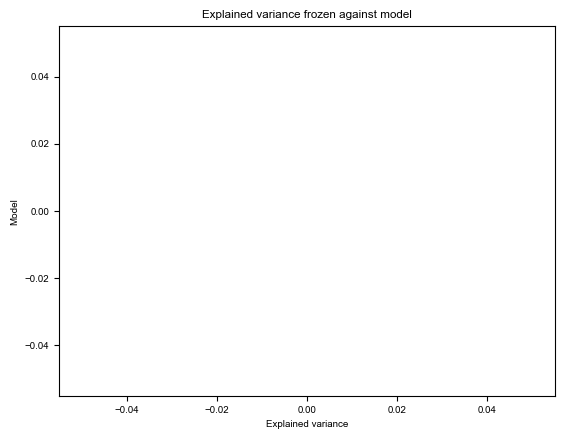

In [6]:
# plot explained variance frozen against curves frozen names
plt.figure()
plt.scatter(explained_variances['master'], curves_names['master'])
plt.xlabel("Explained variance")
plt.ylabel("Model")
plt.title("Explained variance frozen against model")
plt.show()

### Visualize curves master

In [7]:
# for each curve in frozen, visualize the curve
visualize([curve[:,0,:] for curve in curves["master"]], f"master")

### Get dissimilarities

In [11]:
def measure_dissimilarities(group1, group2):
    cka_measure = similarity.make("measure.sim_metric.cka-angular-score")
    procrustes_measure = similarity.make("measure.netrep.procrustes-angular-score")
    dis_cka = np.empty((len(group1), len(group2)))
    dis_procrustes = np.empty((len(group1), len(group2)))
    for i, model1 in enumerate(group1):
        for j, model2 in enumerate(group2):
            dis_cka[i, j] = 1 - cka_measure(model1, model2)
            # test if nan otherwise replace by 1
            dis_procrustes[i, j] = 1- procrustes_measure(model1, model2)
    dsa_comp = DSA.DSA(
        group1, group2,
        n_delays=config["dsa"]["n_delays"],
        rank=config["dsa"]["rank"],
        delay_interval=config["dsa"]["delay_interval"],
        verbose=True,
        iters=1000,
        lr=1e-2,
    )
    dis_dsa = dsa_comp.fit_score()
    return {"cka":dis_cka, "procrusts":dis_procrustes, "dsa":dis_dsa}

In [12]:
for key1 in curves.keys():
    for key2 in curves.keys():
        # check if the dissimilarity has not been computed yet
        if (f"{key1}VS{key2}" or f"{key2}VS{key1}") not in dissimilarities.keys():
            dissimilarities[f"{key1}VS{key2}"]= measure_dissimilarities(curves[key1], curves[key2])
            dissimilarities[f"{key2}VS{key1}"]= dissimilarities[f"{key1}VS{key2}"]

Computing Hankel matrix ...
Hankel matrix computed!
Computing SVD on Hankel matrix ...
SVD complete!
Computing least squares fits to HAVOK DMD ...
Least squares complete! 

Computing Hankel matrix ...
Hankel matrix computed!
Computing SVD on Hankel matrix ...
SVD complete!
Computing least squares fits to HAVOK DMD ...
Least squares complete! 

Computing Hankel matrix ...
Hankel matrix computed!
Computing SVD on Hankel matrix ...
SVD complete!
Computing least squares fits to HAVOK DMD ...
Least squares complete! 

Computing Hankel matrix ...
Hankel matrix computed!
Computing SVD on Hankel matrix ...
SVD complete!
Computing least squares fits to HAVOK DMD ...
Least squares complete! 

Computing Hankel matrix ...
Hankel matrix computed!
Computing SVD on Hankel matrix ...
SVD complete!
Computing least squares fits to HAVOK DMD ...
Least squares complete! 

Computing Hankel matrix ...
Hankel matrix computed!
Computing SVD on Hankel matrix ...
SVD complete!
Computing least squares fits to HA

KeyboardInterrupt: 

### Plot dissimilarities within and across groups

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming `dissimilarities` is a dictionary with the computed dissimilarities


# Function to compute mean, median, and quartiles, excluding the diagonal for within-group comparisons
def compute_stats(dissimilarities, measure, groups):
    stats = {}
    for group in groups:
        dis_values = dissimilarities[group][measure]
        # # Mask the diagonal
        dis_values = dis_values[~np.eye(dis_values.shape[0], dtype=bool)]

        stats[group] = {
            "median": np.median(dis_values),
            "q1": np.percentile(dis_values, 25),
            "q3": np.percentile(dis_values, 75),
        }
    return stats

# Function to plot the stats with error bars for quartiles
def plot_stats(stats, measure_name):
    groups = list(stats.keys())
    medians = np.array([stats[group]["median"] for group in groups])
    q1s = np.array([stats[group]["q1"] for group in groups])
    q3s = np.array([stats[group]["q3"] for group in groups])

    x = np.arange(len(groups))  # the label locations
    width = 0.35  # the width of the bars

    fig, ax = plt.subplots()
    rects2 = ax.bar(
        x + width / 2,
        medians,
        width,
        label="Median",
        yerr=[medians - q1s, q3s - medians],
        capsize=5,
    )

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_xlabel("Groups")
    ax.set_ylabel("Similarity")
    ax.set_title(f"Mean and Median Similarities for {measure_name}")
    ax.set_xticks(x)
    ax.set_xticklabels(groups)
    ax.legend()

    fig.tight_layout()
    plt.show()


In [ ]:
groups = dissimilarities.keys()
groups = ["masterVSpretrain_frozen", "masterVSpretrain_unfrozen", "masterVSmaster"]

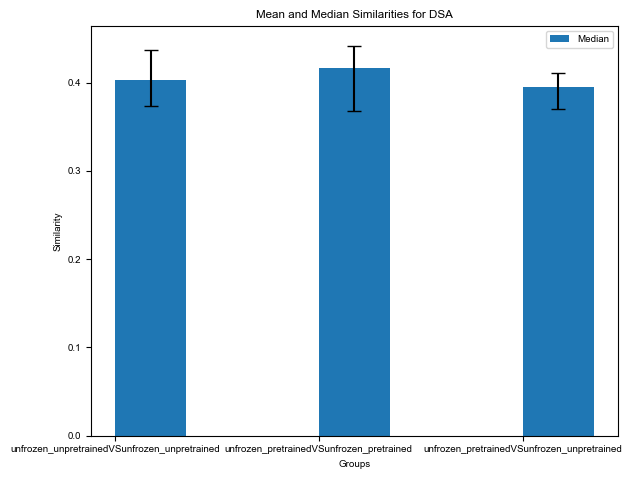

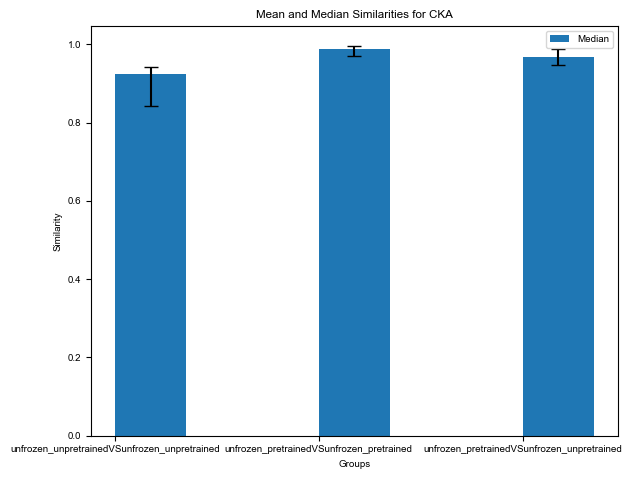

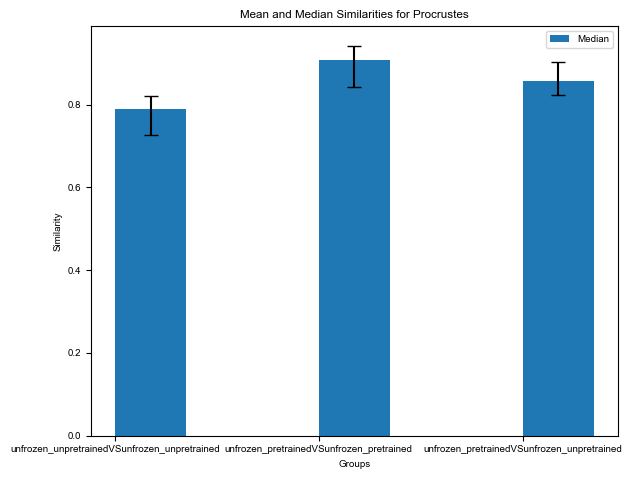

In [ ]:
# Compute stats for each measure
stats_dsa = compute_stats(dissimilarities, "dsa", groups)
stats_cka = compute_stats(dissimilarities, "cka", groups)
stats_procrustes = compute_stats(dissimilarities, "procrusts", groups)

# Plot stats for each measure
plot_stats(stats_dsa, "DSA")
plot_stats(stats_cka, "CKA")
plot_stats(stats_procrustes, "Procrustes")

In [ ]:
# want to create an array of shape (7,7,3) where the first dimension is the group1, the second dimension is the group2 and the third dimension is the measure

dissimilarities_groups = np.empty((7,7,3))
groups = list(curves.keys())
measures = ["dsa", "cka", "procrusts"]
for i, group1 in enumerate(groups):
    for j, group2 in enumerate(groups):
        for k, measure in enumerate(measures):
            dis_values = dissimilarities[f"{group1}VS{group2}"][measure]
            dis_values[~np.eye(dis_values.shape[0], dtype=bool)]
            dissimilarities_groups[i,j,k] = np.median(dis_values)

# save the dissimilarities
with open("dissimilarities_groups.pkl", "wb") as f:
    pickle.dump(dissimilarities_groups, f)
        
                

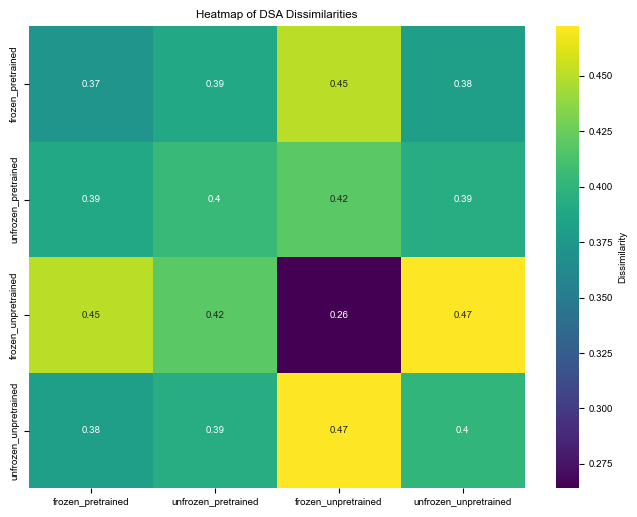

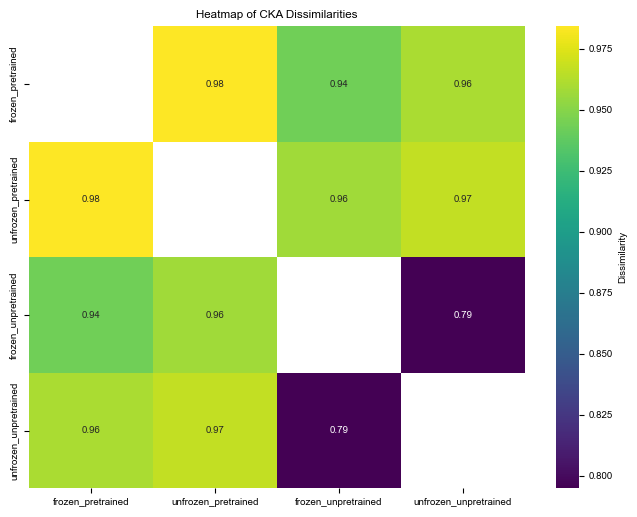

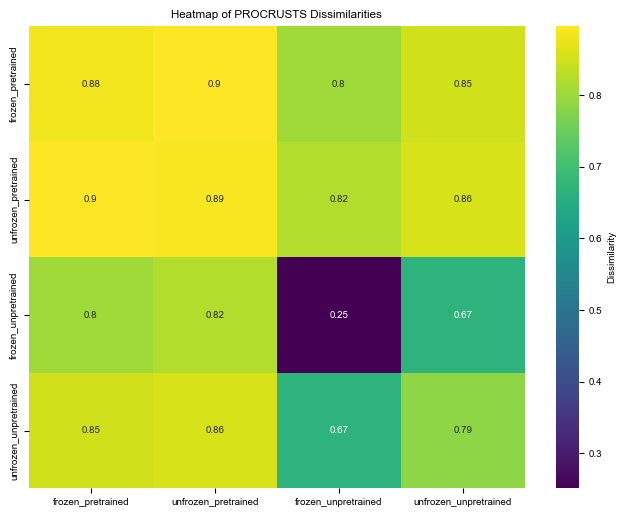

In [ ]:
# Create a heatmap for each measure
import pandas as pd

for k, measure in enumerate(measures):
    data = dissimilarities_groups[:, :, k]
    df = pd.DataFrame(data, index=groups, columns=groups)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(df, annot=True, cmap="viridis", cbar_kws={'label': 'Dissimilarity'})
    plt.title(f'Heatmap of {measure.upper()} Dissimilarities')
    plt.show()